In [6]:
import vizdoom as vzd
import numpy as np
import matplotlib.pyplot as plt
import random

In [7]:
possible_actions = np.zeros((8,6),dtype=int).tolist()
possible_actions[0] = [1,0,0,0,0]
possible_actions[1] = [0,1,0,0,0]
possible_actions[2] = [0,0,-45,0,0]
possible_actions[3] = [0,0,45,0,0]
possible_actions[4] = [0,0,0,50,0]
possible_actions[5] = [0,0,0,-50,0]
possible_actions[6] = [0,0,0,0,30]
possible_actions[7] = [0,0,0,0,-30]
possible_actions

[[1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, -45, 0, 0],
 [0, 0, 45, 0, 0],
 [0, 0, 0, 50, 0],
 [0, 0, 0, -50, 0],
 [0, 0, 0, 0, 30],
 [0, 0, 0, 0, -30]]

In [10]:
from matplotlib import pyplot as plt

game = vzd.DoomGame()
game.load_config('resources/temp_maps/datagen.cfg')
game.set_doom_scenario_path('data/maps_1key_noaug/30x30.wad')

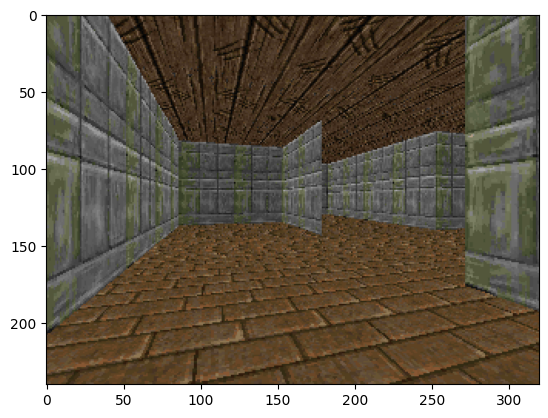

In [15]:
game.set_automap_mode(vzd.AutomapMode.WHOLE)
game.set_seed(42)
game.set_render_hud(False)
game.set_objects_info_enabled(True)
game.set_screen_format(vzd.ScreenFormat.RGB24)
game.set_labels_buffer_enabled(True)
game.set_doom_map('map02')
game.init()
game.new_episode()
game.get_state()

st = game.get_state()

cam = st.screen_buffer

plt.imshow(cam)
plt.show()

game.close()

